In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2018_rahip_brunson/preprocessed_twitter_2018_rahip_brunson.csv')

In [4]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,"gold settles higher recent downdraft, inflatio...",0.283333,0.116667,Positive
1,1,gloves wedding lace ivory bridalgown weddingdr...,0.600000,0.500000,Positive
2,2,boston happening tomorrow _music!! tickets now...,0.602273,-0.306818,Negative
3,3,"第一商品金地金参考価格(1kg税込) 8:45現在 販売 4,784,000円 買取 4,7...",0.000000,0.000000,Neutral
4,4,"gold gains 1 percent dollar retreat, short-cov...",0.000000,0.000000,Neutral


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     20999
Positive    17748
Negative     6853
Name: Analysis, dtype: int64
Total comments:  45600


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :49


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

#x_train = tokenizer.texts_to_matrix(X_train.values.astype(str))
#x_test  = tokenizer.texts_to_matrix(X_test.values.astype(str))

<ipython-input-10-3ebf70ccd52a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-3ebf70ccd52a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
print(train_labels[:10])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [14]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [15]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
1283/1283 [==============================] - 9s 5ms/step - loss: 0.1691 - accuracy: 0.9502 - auc: 0.9962 - val_loss: 0.0680 - val_accuracy: 0.9943 - val_auc: 0.9987
Epoch 2/10
1283/1283 [==============================] - 6s 4ms/step - loss: 0.0688 - accuracy: 0.9952 - auc: 0.9994 - val_loss: 0.0744 - val_accuracy: 0.9961 - val_auc: 0.9996
Epoch 3/10
1283/1283 [==============================] - 6s 5ms/step - loss: 0.0745 - accuracy: 0.9959 - auc: 0.9996 - val_loss: 0.0980 - val_accuracy: 0.9919 - val_auc: 0.9993
Epoch 4/10
1283/1283 [==============================] - 6s 4ms/step - loss: 0.0721 - accuracy: 0.9969 - auc: 0.9996 - val_loss: 0.0673 - val_accuracy: 0.9969 - val_auc: 0.9996
Epoch 5/10
1283/1283 [==============================] - 6s 5ms/step - loss: 0.0687 - accuracy: 0.9966 - auc: 0.9996 - val_loss: 0.0803 - val_accuracy: 0.9943 - val_auc: 0.9998
Epoch 6/10
1283/1283 [==============================] - 6s 4ms/step - loss: 0.0678 - accuracy: 0.9971 - auc: 0.9997 - va

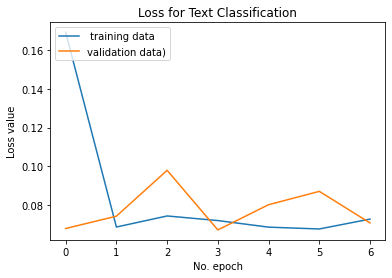

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

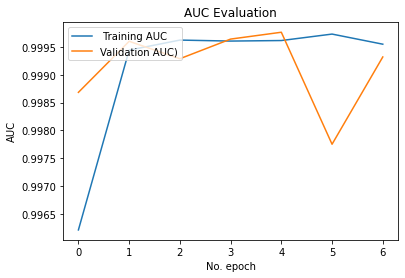

In [17]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
X_test

19810    цены на нефть brent $66.65 (+1.18 / +1.80%) wt...
39208    buy perfect gift paw patrol light sound look-o...
25356    j jesus jewelry jewellery pendant necklace sil...
31266                      turned yellow goldenshower.🤔😆😂🤣
28108    scan results - shooting star candlestick today...
                               ...                        
17833    key differences aware of. lanarealestate buyin...
36956                                  yall damn expensive
42293    antique match safe, metal vesta case, monogram...
18818    bit 'crude' recovery run trading hours: wti $5...
44236    happy wednesday! joe live streaming right coas...
Name: tweet, Length: 4560, dtype: object

In [19]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-19-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
143/143 [==============================] - 0s 1ms/step


array([1, 2, 2, ..., 2, 0, 2])

In [21]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [22]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00      1762
    Negative       0.99      1.00      1.00       706
     Neutral       1.00      0.99      1.00      2092

    accuracy                           1.00      4560
   macro avg       1.00      1.00      1.00      4560
weighted avg       1.00      1.00      1.00      4560

